## Stacked Convolutional and Recurrent Neural Networks

In [2]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import glob
import h5py
import pickle

In [3]:
plt.rcParams['figure.figsize'] = (14, 6)

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling1D, GRU, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [5]:
#SET PATHS
workspace = '/home/speakers/isobieraj/workspace'

hdf5_path = os.path.join(workspace,'dataset.hdf5') 
modelfolder = os.path.join(workspace,'models')
scalerpath = os.path.join(workspace,'scaler.pkl')

In [6]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [7]:
# SCALE THE DATA
scaler = pickle.load(open(scalerpath, 'rb'), encoding='latin1') #python2 object to python3
#scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [8]:
def build_crnn(n_features=n_features, n_frames=n_frames, n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=( n_frames, n_features, 1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', 
               kernel_regularizer=l2(0.01), activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    y = Dropout(0.5)(y)
    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    y = Dropout(0.5)(y)
    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)
    
    y = TimeDistributed(Flatten())(y)
            
    y= GRU(50, return_sequences = True)(y)
    y= Dropout(0.75)(y)  
    
    y= GRU(50, return_sequences = True)(y)
    y= Dropout(0.75)(y) 

    y = GlobalAveragePooling1D()(y)
    
    y = Dense(n_classes, activation='softmax')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [9]:
m = build_crnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 19, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 8, 48)         0         
__________

In [10]:
from keras.utils import plot_model
plot_model(m, to_file='figures/crnn_model_shape.png', show_shapes=True)

<img src='figures/crnn_model_shape.png'>

In [11]:
adam= keras.optimizers.Adam(lr=0.001, decay=1e-5)
m.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [12]:
model_checkpoint = ModelCheckpoint(
                os.path.join(modelfolder, 
                        'crnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
                monitor='val_loss', 
                save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [13]:
history = m.fit(x=X_train, y=y_train, batch_size=250,
                    epochs=200, verbose=True,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 208s 29ms/step - loss: 2.7491 - acc: 0.3041 - val_loss: 2.9466 - val_acc: 0.2047
Epoch 2/200
7079/7079 [==============================] - 179s 25ms/step - loss: 2.0708 - acc: 0.4786 - val_loss: 2.6208 - val_acc: 0.3346
Epoch 3/200
7079/7079 [==============================] - 178s 25ms/step - loss: 1.6233 - acc: 0.5912 - val_loss: 2.6499 - val_acc: 0.3321
Epoch 4/200
7079/7079 [==============================] - 179s 25ms/step - loss: 1.0864 - acc: 0.7425 - val_loss: 2.0965 - val_acc: 0.5061
Epoch 6/200
7079/7079 [==============================] - 178s 25ms/step - loss: 0.9163 - acc: 0.7922 - val_loss: 2.2936 - val_acc: 0.4841
Epoch 7/200
7079/7079 [==============================] - 177s 25ms/step - loss: 0.8291 - acc: 0.8084 - val_loss: 2.0749 - val_acc: 0.5245
Epoch 8/200
7079/7079 [==============================] - 181s 26ms/step - loss: 0.7056 - acc: 0.8404 - val_loss: 1.9669 - val

7079/7079 [==============================] - 278s 39ms/step - loss: 0.1941 - acc: 0.9732 - val_loss: 2.1519 - val_acc: 0.6985
Epoch 00060: early stopping


Text(0,0.5,'Loss')

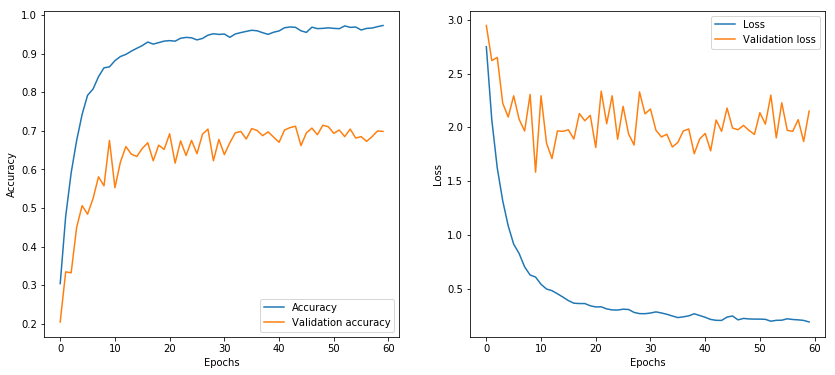

In [14]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [15]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 9s 11ms/step


Accuracy: 0.72


Text(0.5,32.0938,'Predicted label')

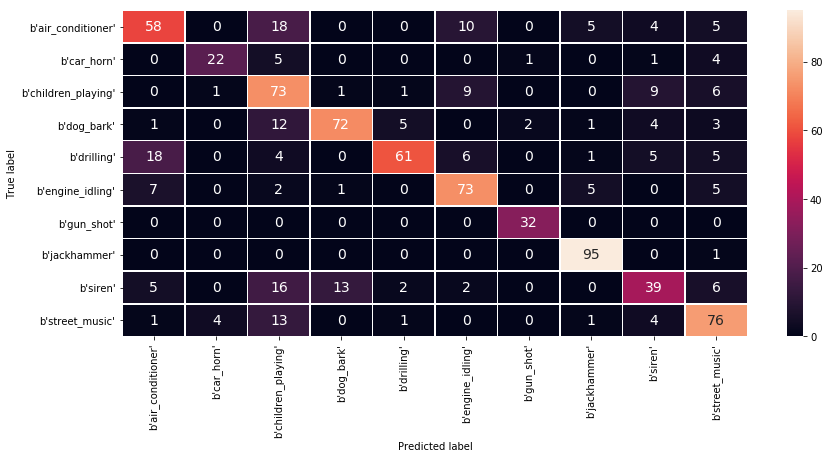

In [16]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, 
            yticklabels=label_list,xticklabels=label_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Final results

|              | CNN           | RNN  | CRNN |
| ------------- |:-------------:| -----:| -----:|
| Accuracy     | 73% | 55% | 72% | 

+ seems that CRNN are doing a good job
+ but proper statistical analysis would be needed to really be able to say that